In [1]:
# The best-performing version of MNB with SMOTE as balancing method, and 
# no stopword removal, no stemming, unigram BOW and MI

In [2]:
import pandas as pd
import nltk as nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import re 
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

### Prepare Dataset

In [3]:
all_events = ''
raw_data = pd.read_csv(all_events, on_bad_lines='skip', sep=';', low_memory=False)

seed = 13062023

In [4]:
# Retreive relevant coloumns
df = pd.DataFrame(raw_data, columns=['Hendelsesbeskrivelse', '2. HENDELSESTYPE', 'AvviksTittel'])
df.rename(columns = {'2. HENDELSESTYPE': 'Hendelsestype'}, inplace = True)

In [5]:
# Dropp Null-rows and rows with too few values or not a part of NOKUP
df.dropna(subset = ['Hendelsesbeskrivelse', 'Hendelsestype'], inplace=True)
df.drop(df[df.Hendelsestype == 'IKT-systemer'].index, inplace=True)
df.drop(df[df.Hendelsestype == 'Annet - pasientuhell'].index, inplace=True) 
df.drop(df[df.Hendelsestype == 'Nei'].index, inplace=True)

In [6]:
# combines titles with the event description for more textual information
df['HendelsesbeskrivelseAvviksTittel'] = df['Hendelsesbeskrivelse'] + ' ' + df['AvviksTittel']

In [7]:
# removes numbers and special characters
def remove_non_letters(corpus):
    corpus_without_br_tag = []
    for doc in corpus:
        # remove html tag
        document = doc.replace('.<br />', '. ')
        document = doc.replace('<br />', '. ')
        #remove all special characters and numbers
        document = re.sub('[^A-Za-zæøåÆØÅ ]+', '', document)
        corpus_without_br_tag.append(document)
    return corpus_without_br_tag

In [8]:
description_title_combined = remove_non_letters(df['HendelsesbeskrivelseAvviksTittel'].tolist())
categories = df['Hendelsestype'].tolist()

### Vectorize train/test set with BOW

In [9]:
# split into train/test set
x_train, x_test, y_train, y_test = train_test_split(description_title_combined, categories, test_size=0.25, random_state=seed)

In [10]:
labelEncoder = preprocessing.LabelEncoder()
vectorizer = CountVectorizer()

In [11]:
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

y_test_vectorized = labelEncoder.fit_transform(y_test)
y_train_vectorized = labelEncoder.fit_transform(y_train)

### Balance the dataset

In [12]:
smote = SMOTE(random_state=seed)
x_train_smote, y_train_smote = smote.fit_resample(x_train_vectorized, y_train_vectorized)

### Feature Selection

In [13]:
selector = SelectPercentile(mutual_info_classif, percentile=70)
selector.fit(x_train_smote, y_train_smote)

SelectPercentile(percentile=70,
                 score_func=<function mutual_info_classif at 0x7fcb53b08430>)

In [14]:
x_train_new = selector.transform(x_train_smote)
x_test_new = selector.transform(x_test_vectorized)

### Train the model

In [15]:
clf = MultinomialNB()

In [16]:
clf.fit(x_train_new, y_train_smote)

MultinomialNB()

### Run the model

In [17]:
predictions_nb = clf.predict(x_test_new)

In [22]:
# map of category names from norwegian to english for display purposes
event_type_english = {
    'Blod og blodprodukter': 'Blood and Blood Products',
    'Diagnostikk, behandling og pleie': 'Diagnostics, Treatment, and Care',
    'Dokumentasjon/ informasjon': 'Documentation and Information',
    'Infeksjon': 'Infection',
    'Labaratorietjenester': 'Labaratory Services',
    'Legemidler': 'Drugs',
    'Medisinsk utstyr': 'Medical Equipment',
    'Pasientadministrasjon/ samhandling': 'Patient Administration and Coordination',
    'Pasientatferd': 'Patient Behavior',
    'Pasientuhell og fall': 'Falls and Accidents'
}

Multinominal Naive Bayes
The Accuracy score is 0.760997478285234
Total Recall Score is 0.724166644494065
Total Precision Score is 0.7199744438334661
Total macro F1 score is 0.7182172034231848
                                         precision    recall  f1-score   support

               Blood and Blood Products       0.72      0.70      0.71        69
       Diagnostics, Treatment, and Care       0.73      0.62      0.67      2528
          Documentation and Information       0.52      0.42      0.46       810
                              Infection       0.62      0.78      0.69       116
                    Labaratory Services       0.88      0.96      0.92      1632
                                  Drugs       0.76      0.87      0.81      1364
                      Medical Equipment       0.64      0.49      0.55       226
Patient Administration and Coordination       0.68      0.78      0.72      1979
                       Patient Behavior       0.72      0.74      0.73       4

<Axes: >

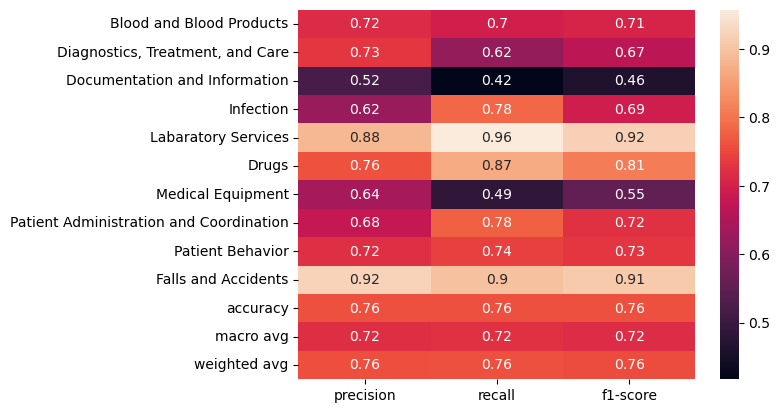

In [29]:
print("Multinominal Naive Bayes")
print("The Accuracy score is {}".format(accuracy_score(y_test_vectorized, predictions_nb)))

print("Total Recall Score is {}".format(recall_score(y_test_vectorized, predictions_nb, average="macro")))

print("Total Precision Score is {}".format(precision_score(y_test_vectorized, predictions_nb, average="macro")))

print("Total macro F1 score is {}".format(f1_score(y_test_vectorized, predictions_nb, average="macro")))

print(classification_report(y_test_vectorized, predictions_nb, target_names=event_type_english.values()))
clf_report = classification_report(y_test_vectorized, predictions_nb, target_names=event_type_english.values(), output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)


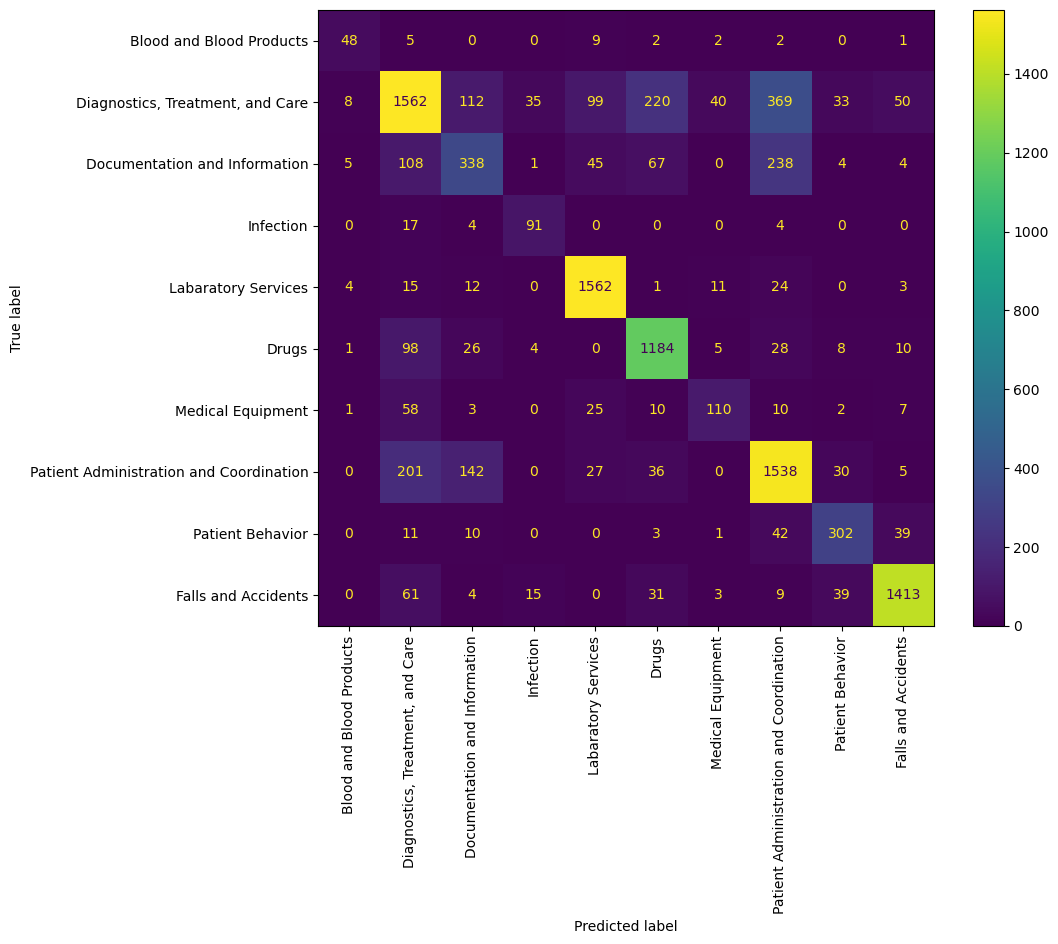

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))

cm = confusion_matrix(y_test_vectorized, predictions_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelEncoder.inverse_transform(clf.classes_))

disp.plot(ax=ax)
ax.set_yticklabels(labels=event_type_english.values())
ax.set_xticklabels(labels=event_type_english.values(), rotation=90)

plt.show(block=True)

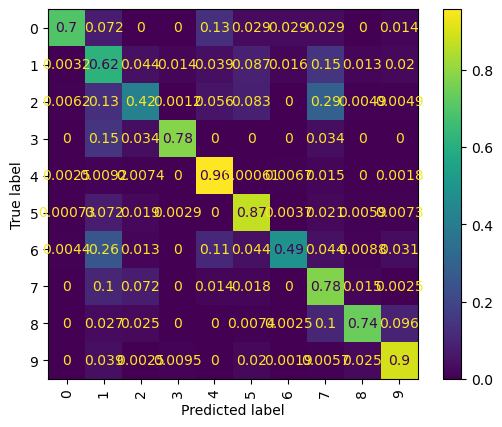

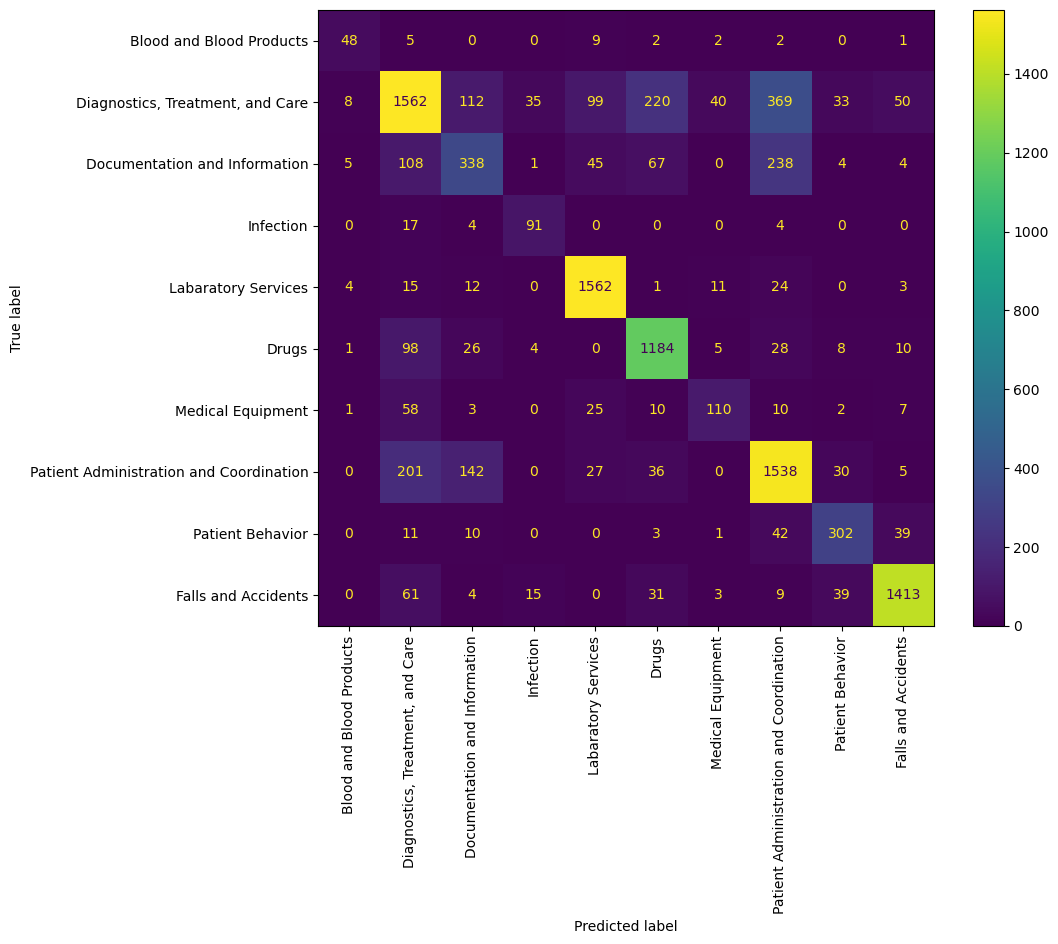

In [26]:
#normalized confusion matrix over true conditions (rows)
disp2 = ConfusionMatrixDisplay.from_predictions(y_test_vectorized, predictions_nb, normalize="true", xticks_rotation="vertical", display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(10,8))

disp.plot(ax=ax)
ax.set_yticklabels(labels=event_type_english.values())
ax.set_xticklabels(labels=event_type_english.values(), rotation=90)

plt.show(block=True)

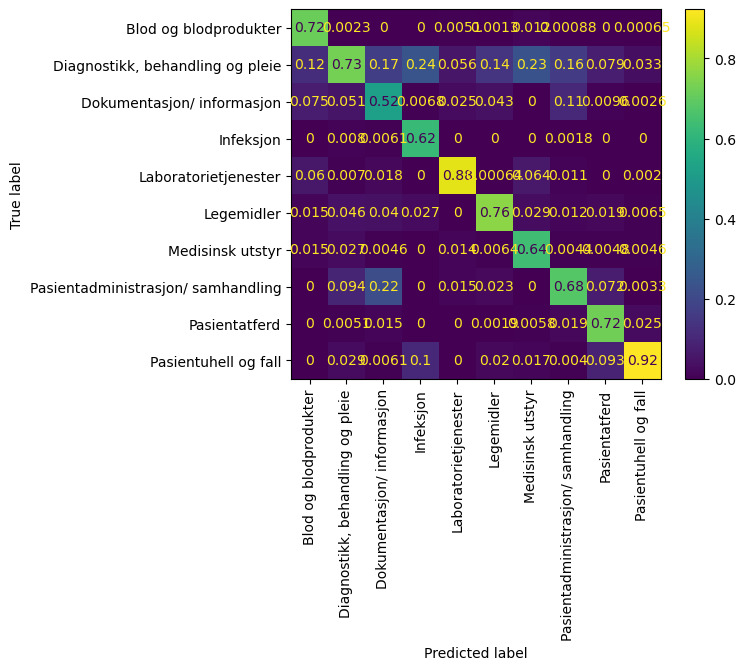

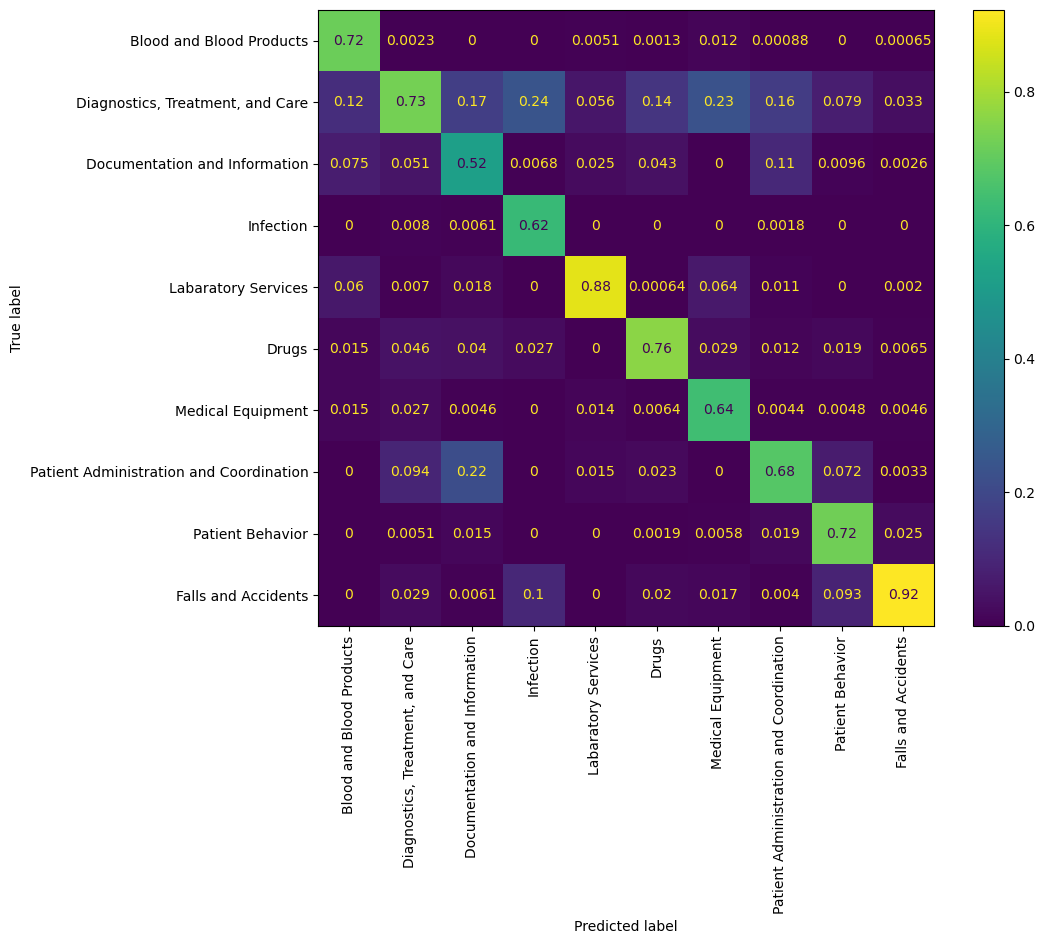

In [25]:
#normalized confusion matrix over predicted conditions (columns) 
disp2 = ConfusionMatrixDisplay.from_predictions(y_test_vectorized, predictions_nb, normalize="pred", xticks_rotation="vertical", display_labels=labelEncoder.inverse_transform(clf.classes_))

fig, ax = plt.subplots(figsize=(10,8))

disp2.plot(ax=ax)
ax.set_yticklabels(labels=event_type_english.values())
ax.set_xticklabels(labels=event_type_english.values(), rotation=90)

plt.show(block=True)